# Participation on the Digit Recognizer competition using Pytorch - accuracy of 0.98271


---

Notebook for my first participation on a Kaggle competition.
Used the kernels [Introduction to CNN Keras - Acc 0.997 (top 8%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) and [PyTorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader) as inspiration.

## Import and installation of the necessary resources to download the data and save trained models on Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/Colab Notebooks'
drive_full_path = drive_path + '/K_Digit_Recognizer'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
drive_full_path

'/content/drive/My Drive/Colab Notebooks/K_Digit_Recognizer'

In [0]:
!pip install kaggle

In [0]:
from google.colab import files

uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import the authentication file from Kaggle.

In [0]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2627            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      10762            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4442            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         34           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2649           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [0]:
!kaggle competitions download -c digit-recognizer

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


Access all the currently active competitions and download the data from the Digit Recognizer one.

In [0]:
!ls

drive  sample_data  sample_submission.csv  test.csv  train.csv


In [0]:
#Imports for constructing the Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

#Imports for handling data
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

#Imports for visualization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#import torchvision.models as models
#from torch.utils.data.sampler import SubsetRandomSampler
#from sklearn.model_selection import train_test_split



In [0]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

Check if we're running on a GPU

In [0]:
from PIL import Image

class CSVDataset(Dataset):
    
    def __init__(self, data, height, width, channels, transform=None, test=False):
        self.data = data
        self.transform = transform
        self.height = height
        self.width = width
        self.channels = channels
        self.test = test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        
        if self.test:
          image_numpy = self.data.iloc[index].values.astype(np.uint8).reshape(
              (self.height, self.width))
          transform = transforms.ToTensor()
          image =transform(image_numpy)   #transform.toTensor already /255
          return image
        
        else:
          image_numpy = self.data.iloc[index, 1:].values.astype(np.uint8).reshape(
              (self.height, self.width))
          image = Image.fromarray(image_numpy.astype('uint8'))

          label = int(self.data.iloc[index, 0])

          if self.transform is not None:
              image = self.transform(image)   #transform.toTensor already /255

          return image, label

"class CSVDataset(Dataset):\n    \n    def __init__(self, data, height, width, channels,transform=None):\n        self.data = data\n        self.transform = transform\n        self.height = height\n        self.width = width\n        self.channels = channels\n        \n    def __len__(self):\n        return len(self.data)\n    \n    def __getitem__(self, index):\n        # load image as ndarray type (Height * Width * Channels)\n        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]\n        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)\n        image_numpy = self.data.iloc[index, 1:].values.astype(np.uint8).reshape(\n            (self.height, self.width))\n        image = Image.fromarray(image_numpy.astype('uint8'))\n\n        label = int(self.data.iloc[index, 0])\n        \n        if self.transform is not None:\n            image = self.transform(image)   #transform.toTensor already /255\n            \n        return i

Custom Dataset to handle images from a CSV file.

In [0]:
train_data = pd.read_csv('train.csv',dtype = np.float32)
test_data = pd.read_csv('test.csv',dtype = np.float32)

Download the train and test data into a pandas dataframe.

In [0]:
#ratio of data used for trainning, the rest will be used for validation
train_ratio=0.85

div = int(train_data.shape[0] * train_ratio)

#trainning data
train = train_data.iloc[:div]
#validation data
val = train_data.iloc[div:]

Divide the data for trainning and validation.

In [0]:
data_transforms = {'train':transforms.Compose([
                      transforms.RandomRotation(10),  #rotate the image by a random value between -10 and 10
                      transforms.ToTensor()]) ,       #transforms the data in a torch.FloatTensor with values between 0.0 and 1.0
                   'val':transforms.Compose([
                          transforms.ToTensor()])
                  }


Define the transforms to apply to the trainning and validation sets.

In [0]:
#Convert the data to datasets of 28x28x1 tensors with the corresponding transforms applied
train_dataset = CSVDataset(train, 28, 28, 1, transform=data_transforms['train'])
val_dataset = CSVDataset(val, 28, 28, 1, transform=data_transforms['val'])

Put the data in a dataset.

In [0]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

Define the batch size and create data loaders used to iterate the datasets.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


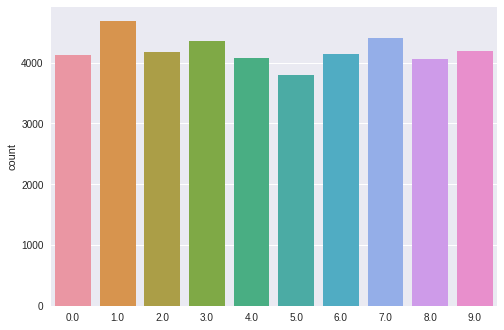

In [0]:
g = sns.countplot(train_data.label.values)

Overview of the total number of images in each class.

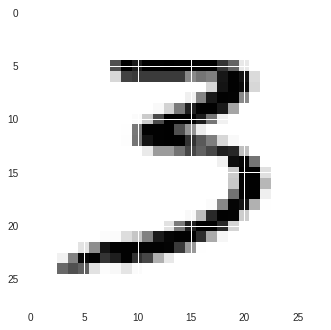

In [0]:
plt.imshow(train_dataset[25][0].view(28,28))

Example of one of the images used as input.

In [0]:
class MNISTNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
      # 1-> number of channels in the input (1 because it's a grayscale image)
      # 32 -> number of kernels used, and the number of channels in the input
      # 5 -> heigth and width of the kernels
      # padding -> adds a padding of 2 in order to not reduce the size of the image
      torch.nn.Conv2d(1, 32, 5, padding=2),    #convolutional layer
      nn.ReLU(),                               #activation layer, uses Rectified Linear Unit
      torch.nn.Conv2d(32, 32, 5, padding=2),
      nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2)        #Pooling layer, chooses max value of a 2x2 square
    ) 
    #data comes out of this layer in the shape 32x14x14
    self.layer2 = nn.Sequential(
      torch.nn.Conv2d(32, 64, 3, padding=1),
      nn.ReLU(),
      torch.nn.Conv2d(64, 64, 3, padding=1),
      nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2)
    ) #64, 7, 7
    self.fc1 = torch.nn.Linear(7*7*64, 256)
    self.fc2 = torch.nn.Linear(256, 10)
   
  def forward(self, x):
    x = self.layer1(x)
    x = F.dropout(x, p=0.25)                  #applies a dropout layer, with 0.25 probability of ignoring each element of the input tensor.
    x = self.layer2(x)
    x = F.dropout(x, p=0.25)
    x = x.reshape(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    out = F.softmax(self.fc2(x))
    return out
    

In [0]:
def save_model(model, epochs=0, val_loss=-1):
  '''function to save the state of the model, the state of the optimizer, 
  number of current epochs and validation loss'''
  
  checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 
              'epochs': epochs, 'val_loss': val_loss}
  torch.save(checkpoint, drive_full_path + '/checkpoint.pt')
  print("Model Saved")

In [0]:
def load_model(checkpoint):
    '''function to load a model and a optimizer with the respective state dicts,
    returning them and the lowest validation loss associated with them'''
    model = MNISTNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    val_loss = checkpoint['val_loss']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, val_loss

In [0]:

try:                   #if there is a file with a checkpoint of trainning load it and use its data
  
    #load te checkpoint from the file located in Google Drive
    checkpoint = torch.load(drive_full_path + '/checkpoint.pt')
    
    model, optimizer, val_loss = load_model(checkpoint)
    
    # track change in validation loss
    valid_loss_min = val_loss
    
    
except FileNotFoundError:   #if there is no file with a checkpoint of trainning, start fresh

    #instatiate the model
    model = MNISTNetwork()

    #define the optimizer as Adam, give him the model's parameters and define the learning rate as 0.001
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # track change in validation loss
    valid_loss_min = np.Inf
    

#define the loss as Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

#schedule the lr to decrease by half after every 3 epochs without improvement
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True, min_lr=0.00001)

Instiatiate the model and create the necessary resources necessary to train it.

In [0]:
# number of epochs to train the model
n_epochs = 25

# number of epochs without improvement that triggers an early stop in trainning
early_stop = 7
es_counter = 0


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy=0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_number, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #give feedback on current batch of the epoch
        if batch_number%50 == 0:
            print("batch number: {}".format(batch_number))
            
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        _,pred=torch.max(output,1)
        accuracy += torch.sum(pred==target.data)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    accuracy = accuracy.double()/len(val_loader.dataset)
    
    # confirm if the validation loss is decreasing in order to reduce lr
    scheduler.step(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,accuracy))
    
    # save model if validation loss has decreased, if not increase early stop counter 
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
        save_model(model, epoch, valid_loss)
        valid_loss_min = valid_loss
        es_counter = 0
    else:
        es_counter+=1
    
    #if certain number of epochs have passed without improvement stop the trainning
    if es_counter >= early_stop:
        print("\n\nEarly stop, no improvements in {} epochs".format(early_stop))
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch number: 0
batch number: 50
batch number: 100
batch number: 150
batch number: 200
batch number: 250
Epoch: 1 	Training Loss: 1.498680 	Validation Loss: 1.489930	Accuracy: 0.971270
batch number: 0
batch number: 50
batch number: 100
batch number: 150
batch number: 200
batch number: 250
Epoch: 2 	Training Loss: 1.494231 	Validation Loss: 1.488496	Accuracy: 0.972222
batch number: 0
batch number: 50
batch number: 100
batch number: 150
batch number: 200
batch number: 250
Epoch: 3 	Training Loss: 1.493846 	Validation Loss: 1.491277	Accuracy: 0.969841
batch number: 0
batch number: 50
batch number: 100
batch number: 150
batch number: 200
batch number: 250
Epoch: 4 	Training Loss: 1.494865 	Validation Loss: 1.486612	Accuracy: 0.974762
Validation loss decreased (1.488192 --> 1.486612).  Saving model ...
Model Saved
batch number: 0
batch number: 50
batch number: 100
batch number: 150
batch number: 200
batch number: 250
Epoch: 5 	Training Loss: 1.491709 	Validation Loss: 1.489294	Accuracy: 0.9

In [0]:
test_dataset = CSVDataset(test_data, 28, 28, 1, test=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [0]:
predictions = pd.DataFrame(columns = ['ImageId', 'Label'])

In [0]:
checkpoint = torch.load(drive_full_path + '/checkpoint.pt')

model, _, _ = load_model(checkpoint)

In [0]:
model.eval()
image_id = 0
with torch.no_grad():
  for data in test_loader:
    image_id+=1
    output = model(data)
    _,pred=torch.max(output,1)
    
    #row = {'ImageId' : image_id, 'Label' : pred}
    serie = pd.Series([image_id, int(pred)],index=predictions.columns)
    predictions = predictions.append(serie, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
predictions.to_csv('submission.csv', index=False)
files.download('submission.csv')